### Scale Models Analysis

This notebook analyzes and compares the experimental clock rates, event types, and message queue lengths of machines across different internal clock rates.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [36]:
# Helper Functions

# Iterate across trials and convert csvs to a list of dataframes
def csv_to_df(directory):
    processes = [[], [], []]
    for filename in os.listdir(directory):
        trial = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isdir(trial):
            sorted_list = sorted(os.listdir(trial))
            for i, log in enumerate(sorted_list):
                log_path = os.path.join(trial, log)
                processes[i].append(pd.read_csv(log_path))

    return processes

# Average results across dataframes
def average_dfs(processes, col_name):
    data = []
    for i in range(len(processes)):
        cols = []
        minimum = len(processes[i][0][col_name])
        trials = len(processes[i])
        for j in range(trials):
            col = processes[i][j][col_name]
            cols.append(col)
            minimum = min(minimum, len(col))
        normalized = []
        for k in range(trials):
            normalized.append(cols[k][:minimum])
        val = pd.concat([j for j in normalized]).groupby(level=0).mean()
        data.append(val)

    return data

# Helper function to format graph
def format_legend(log):
    crs = log.split('_')
    return [crs[1], crs[2], crs[3]]

# Graph results clock rate or message queue length data
def graph(directory, col_name, normal=False):
    processes = csv_to_df(directory)
    data = average_dfs(processes, col_name)
    global_time = average_dfs(processes, 'global time')

    name = col_name.split(" ")
    first = name[0].capitalize()
    second = name[1].capitalize()
    log = directory.split('/')[1].capitalize()
    crs = format_legend(log)
    if normal:
        for i in range(len(data)):
            data[i] /= int(crs[i])

    for i in range(len(data)):
        plt.plot(global_time[i], data[i], alpha=0.7)

    title = f"{log}: {first} {second} Comparison"
    plt.title(title)
    plt.xlabel('Global Time (seconds)')
    plt.ylabel(f"{first} {second}")
    plt.legend([f'Machine {i+1} (clock rate = {cr})' for i, cr in enumerate(crs)])
    plt.show()

# Display event counts for each process
def graph_events(directory):
    log = directory.split('/')[1].capitalize()
    processes = csv_to_df(directory)
    data = []
    for i in range(len(processes)):
        cols = []
        for j in range(len(processes[i])):
            col = processes[i][j]['event type'].value_counts()
            zeros = pd.Series([0, 0, 0], index=['internal', 'receive', 'send'])
            col = col.add(zeros, fill_value=0)
            cols.append(col)
        val = pd.concat([k for k in cols]).groupby(level=0).mean()
        data.append(val)

    fig, axs = plt.subplots(len(processes), figsize=(10, 10))
    fig.tight_layout(pad=5.0)
    fig.suptitle(f'Event Comparison: {log}', size=16)
    indices = data[0].index.to_list()
    crs = format_legend(log)
    titles = [f'Machine {i+1} (clock rate = {cr})' for i, cr in enumerate(crs)]
    for i in range(len(processes)):
        axs[i].bar(indices, data[i], color=['blue', 'red', 'green'], width = 0.4)
        axs[i].set_title(titles[i])
    plt.show()

# calculate and graph average logical clock jumps
def calculate_jumps(directory):
    log = directory.split('/')[1].capitalize()
    processes = csv_to_df(directory)
    average_jumps = []
    stds = []
    for i in range(len(processes)):
        jumps = []
        trials = len(processes[i])
        for j in range(trials):
            jump = np.diff(processes[i][j]['logical clock'])
            jumps.append(jump)
        concatenated = np.concatenate([k for k in jumps])
        avg = np.mean(concatenated)
        std = np.std(concatenated)
        average_jumps.append(round(avg, 2))
        stds.append(round(std, 2))

    crs = format_legend(log)
    print("Average Jump Sizes (\u00B1 std)")
    for i, cr in enumerate(crs):
        print(f"Machine {i+1} (clock rate {cr}): {average_jumps[i]} (\u00B1 {stds[i]})")

## Equivalent Clock Rates

We first graph the average event counts of 3 machines with equivalent logical clock rates of 1. Results were averaged across 10 trials. According to the probabilities in the specs, if a machine's queue is non-empty, than an internal event is triggered 70% of the time, while a send operation occurs 30% of the time.

As expected, ratios of internal events to send events for all machines was roughly 7:3. On average over 60 seconds, receive events were triggered 17-19 times, while send events occurred 13-15 times for all machines. Since there is a 10% chance that a process sends an event to both of the other processes, we expect that probability of receive events to be higher than send events when the logical clock rates are all equivalent.

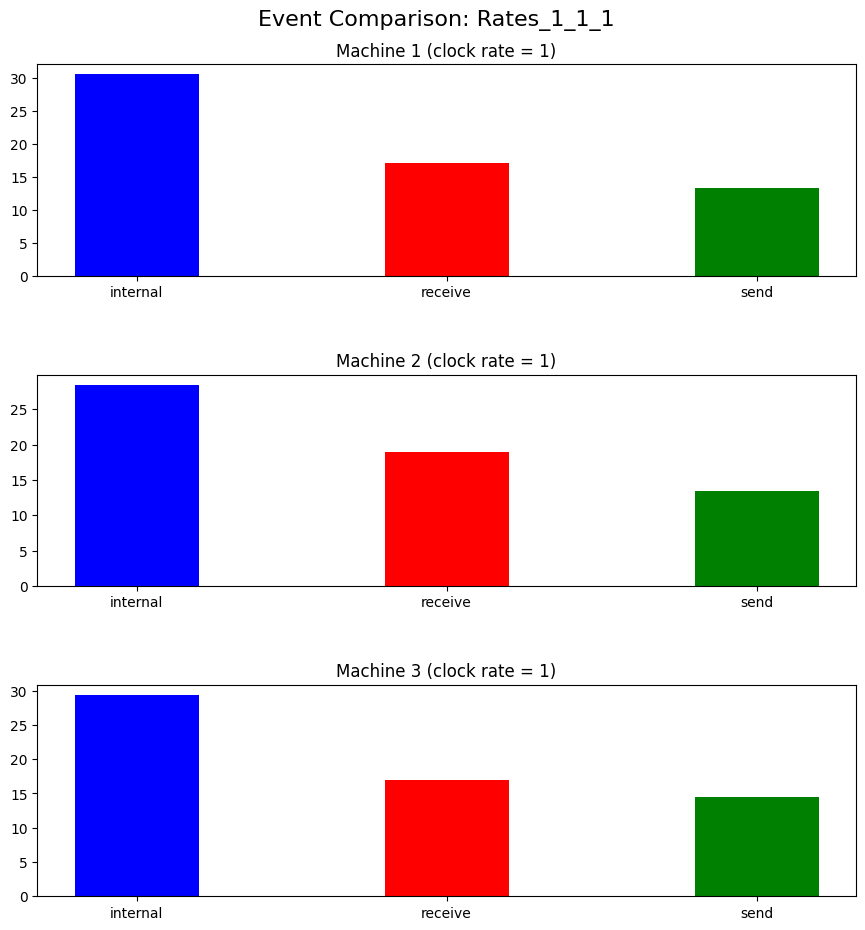

In [13]:
graph_events('logs/rates_1_1_1')

Additionally, the logical clock rates of each process was equivalent, and matched the global system time; i.e., there seem to be no gaps that occur. Since each event logical clock rate of a machine was 1, the logical clock was incremented by 1 after each event, regardless of whether the process triggered an internal, send, or receive event. 

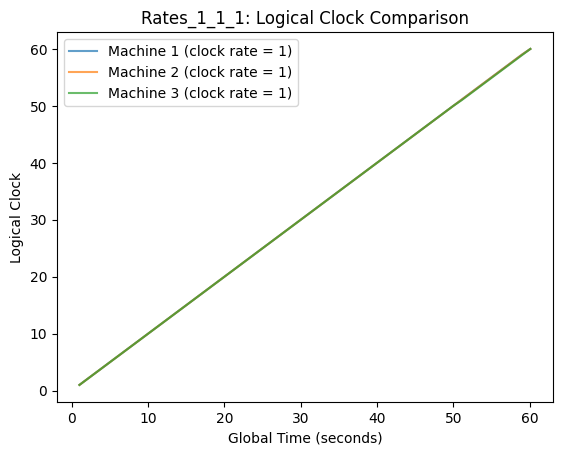

In [14]:
graph('logs/rates_1_1_1', 'logical clock', normal=False)

We can analyze the jumps in logical clock values by calculating the average logical clock jump values: as expected, we see that average jump value is 1 for all machines.

In [37]:
calculate_jumps('logs/rates_1_1_1')

Average Jump Sizes (± std)
Machine 1 (clock rate 1): 1.0 (± 0.0)
Machine 2 (clock rate 1): 1.0 (± 0.0)
Machine 3 (clock rate 1): 1.0 (± 0.0)


## Differing Clock Rates

### Clock Rates 1, 3, 6
For comparison, we graph the results of the event type counts when running the experiment with 3 machines with clock rates of 1, 3, and 6, respectively. The majority of events for Machine 1 were receive events. Since the clock rate of this machine was significantly lower than all the other machines, it's message queue was constantly non-empty, meaning that it was unable to trigger an internal or send event. For Machine 2 and Machine 3, the ratio of internal to send events was similarly close to 7:3. However, receive events made up almost 30% of the total events for Machine 2, compared to less than 5% of all events for Machine 3, which can be explained by the higher clock rate of Machine 3.

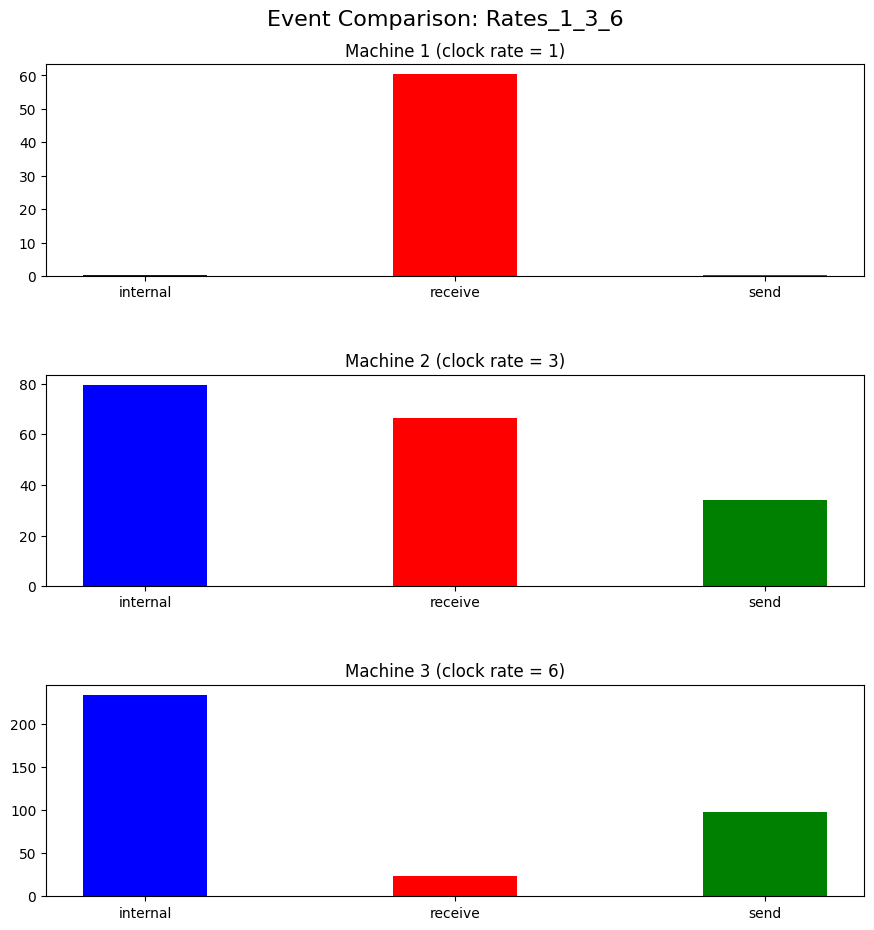

In [15]:
graph_events('logs/rates_1_3_6')

Graphing the message queue lengths and logical clock values over time for each machine tells a similar story: since the message queue of Machine 1 is always full (and increasing), it will never be able to send a message or log an internal event.

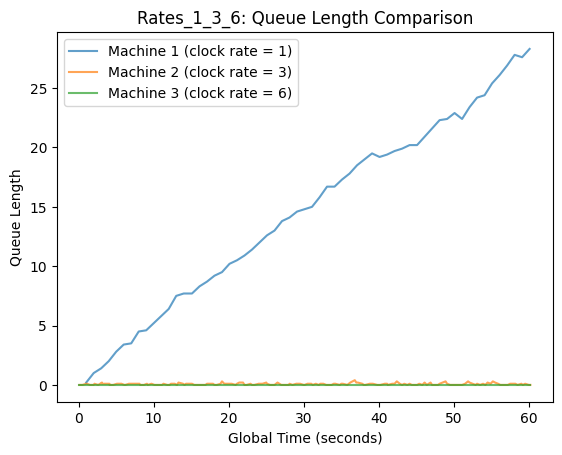

In [16]:
graph('logs/rates_1_3_6', 'queue length')

Similarly, we can see that the internal logical clock value of Machine 1 is drifting from both the true system time and the logical clock values of Machines 2 and 3. Machine 1 is unable to "keep up" with the logical clock of Machine 2 and 3, since it only increments once per second and constantly has a backlog of messages. Interestingly though, Machine 2 is able to keep up with Machine 3, meaning that there are enough gaps in its logical clock values / enough receives happening to keep pace with Machine 2's timings.

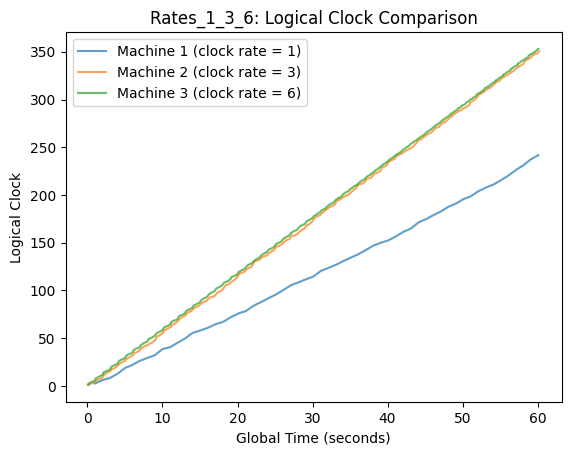

In [17]:
graph('logs/rates_1_3_6', 'logical clock')

Below we've graphed the "normalized" logical clock versus the global time – normalized meaning that we've divided the logical clock value by the clock rate. This metric is what we would expect would match the global time if each machine was in a void, since each machine has clock rate number of events per second. 

We see that the normalized logical clock of Machine 3, with the largest clock rate, accurately matches the global time. This makes sense since no gaps really occur for Machine 3, since it's clock does not run behind the slower machines. On the other hand, Machine 1 and 2's normalized logical clocks drift away from the exact global time, which indicates that there are gaps/jumps in their logical clocks. This effect is more drastic for Machine 1, as it has the slowest clock rate.

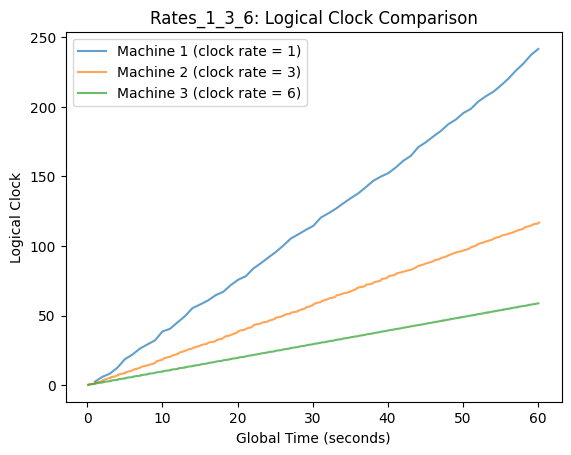

In [18]:
graph('logs/rates_1_3_6', 'logical clock', normal=True)

Calculating the average jump values for each machine, we see that there is an inverse relationship between clock rate and average jump size. Machine 1 always increments its clock rate value by 1.

In [38]:
calculate_jumps('logs/rates_1_3_6')

Average Jump Sizes (± std)
Machine 1 (clock rate 1): 4.05 (± 3.75)
Machine 2 (clock rate 3): 1.96 (± 2.07)
Machine 3 (clock rate 6): 1.0 (± 0.0)


### Clock Rates 2, 2, 5

Now, let's similarly analyze machines with clock rates 2, 2, and 5 respectively, averaged over 5 trials.

We see below that Machine 1 and 2 have about the same ratio of event types, as expected since they have the same clock rate. Additionally, they have far more receive events than Machine 3, which matches our observations from the previous section that slower speeds see a larger percentage of receive events.

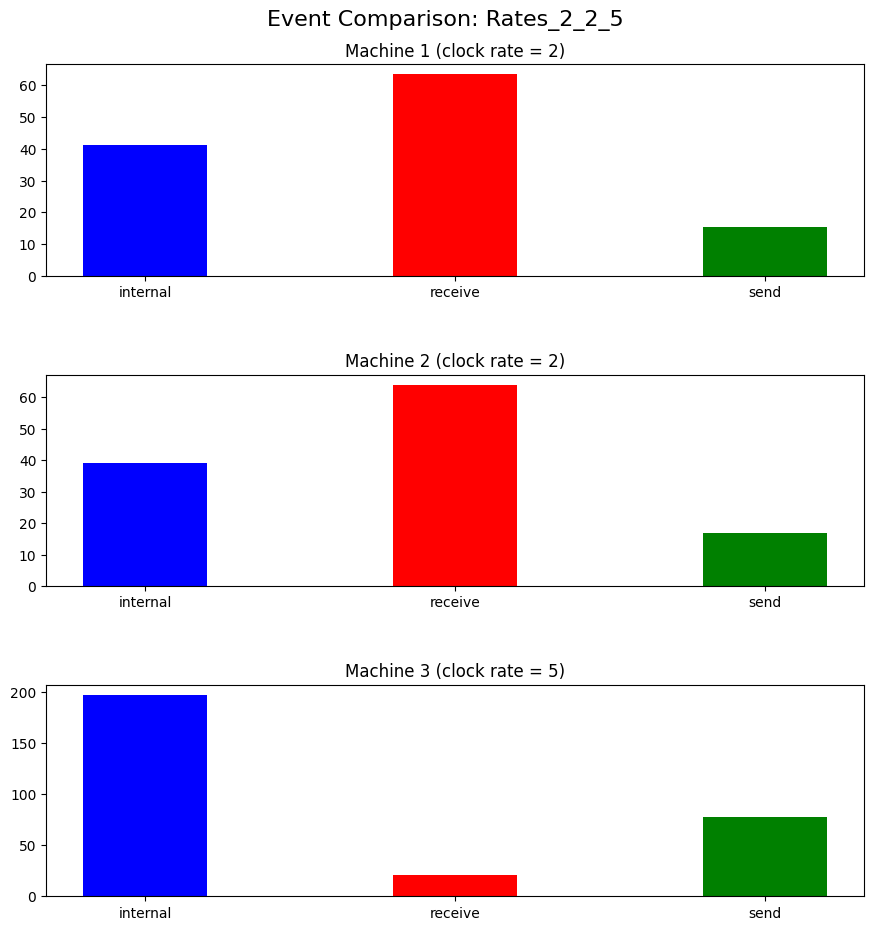

In [19]:
graph_events('logs/rates_2_2_5')

Looking at the queue length graph, we see that unlike the case where the rates were 1, 3, and 6, the queue lengths for all of the machines stays quite small, constantly staying below 1 on average. We do see a slightly higher average for Machines 1 and 2, since they have slower clocks, but overall these machines are able to keep up with the pace of messages and do not build up a large backlog on their queue. This is likely due to the fact that the difference in rates is smaller now, and also there is only a single machine with a faster rate than Machines 1 and 2.

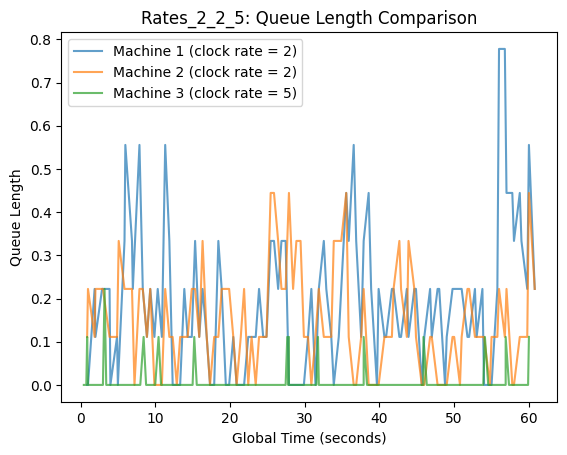

In [39]:
graph('logs/rates_2_2_5', 'queue length')

Below we see that the logical clocks of all of the machines are able to keep pace with each other, for the same reasoning that the queues do not get backlogged.

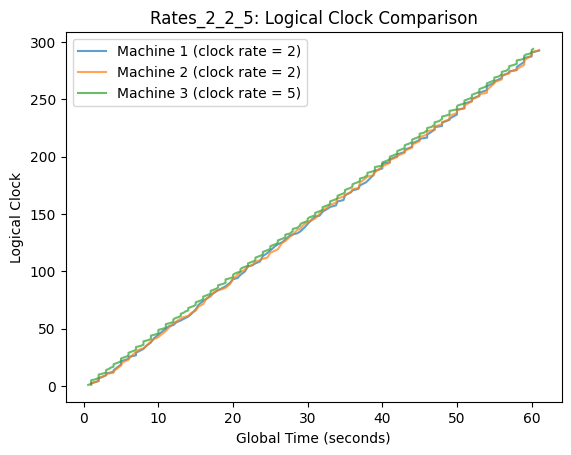

In [21]:
graph('logs/rates_2_2_5', 'logical clock')

We also see that when the logical clock is normalized, the only machine that matches the global time is Machine 3, which is again because it has the fastest clock rate, so there are little/no gaps in its logical clock. On the other hand, Machines 1 and 2 drift away from the global time, meaning that they have gaps in their logical clock values which is needed to keep pace with the speed of Machine 3's logical clock.

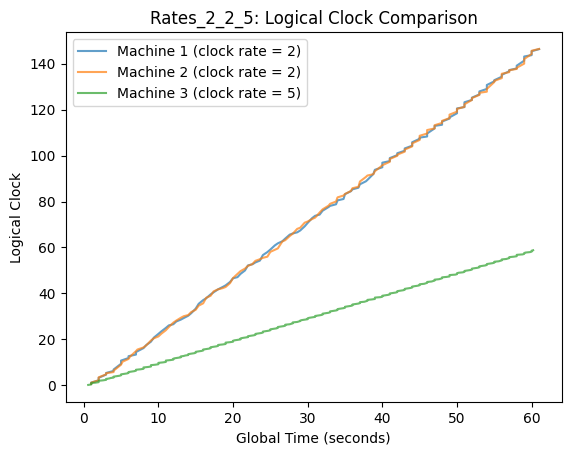

In [22]:
graph('logs/rates_2_2_5', 'logical clock', normal=True)

### Clock rates 2, 5, 5

Now, let's look at machines with clock rates 2, 5, and 5 respectively.

Machine 2 and 3 have about the same ratio of event types, as expected since they have the same clock rate. Machine 1 has far more receive events than Machines 2 and 3, since it operates at a slower speed. Interestingly, note that Machine 1 here has far fewer internal and send events compared to Machine 1 in the previous section (with rates 2, 2, 5), which can be attributed to there now being two machines sending messages to Machine 1 at a high frequency.

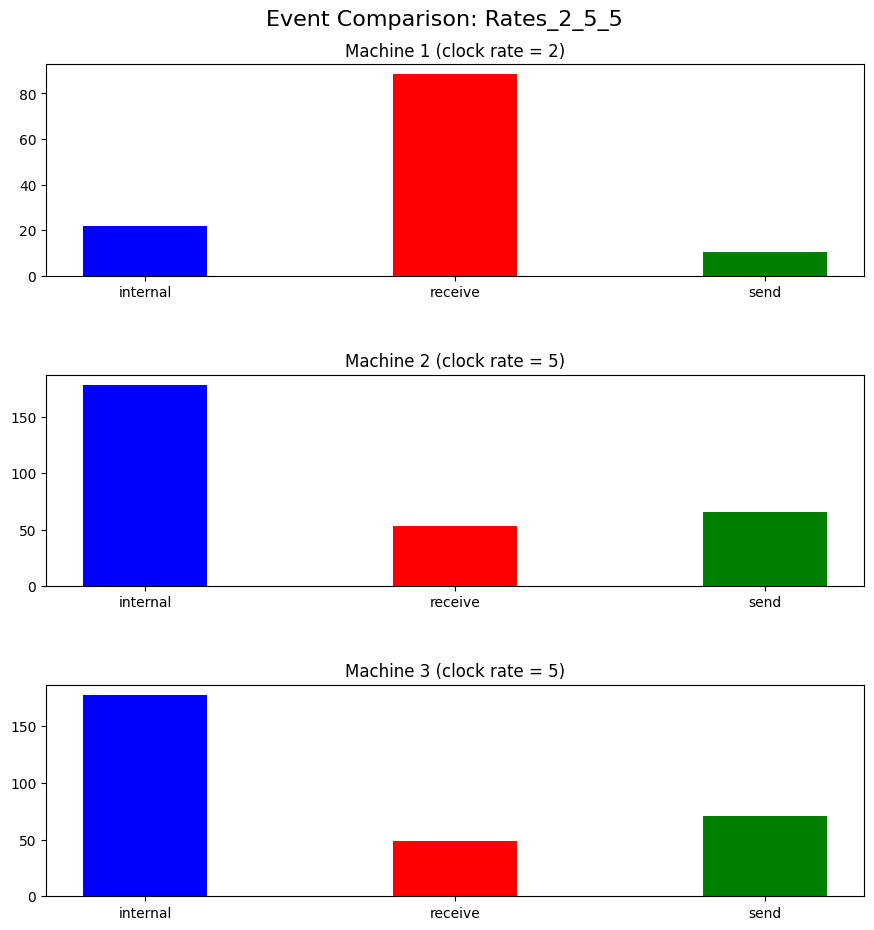

In [23]:
graph_events('logs/rates_2_5_5')

We see now that unlike in the previous section, Machine 1 does get backlogged at times, with the average queue length getting up to around 3.5. The other machines have very low queue lengths, never exceeding 1. Again, this makes sense since Machine 1 is receiving messages from both Machin 2 and 3 which have high clock rates, so it is not able to completely keep up. The queue lengths are still significantly lower here than the first section with rates 1, 3, 6, as the clock rates here do not differ by as much.

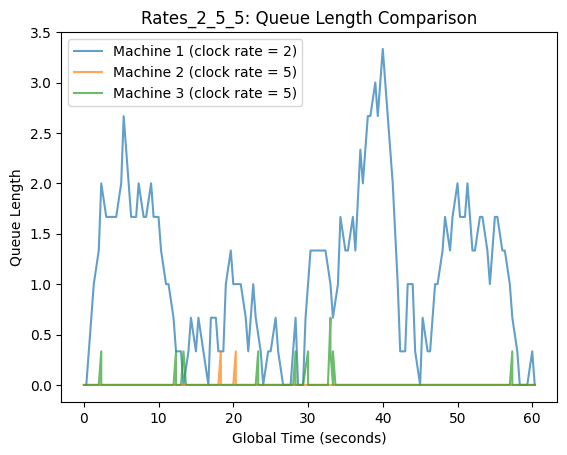

In [24]:
graph('logs/rates_2_5_5', 'queue length')

Due to the slight backlog in the queue for Machine 1, we see that its logical clock struggles a little bit to keep pace with Machine 2 and 3. However, the difference is only very slight, as the queue lengths are still relatively small.

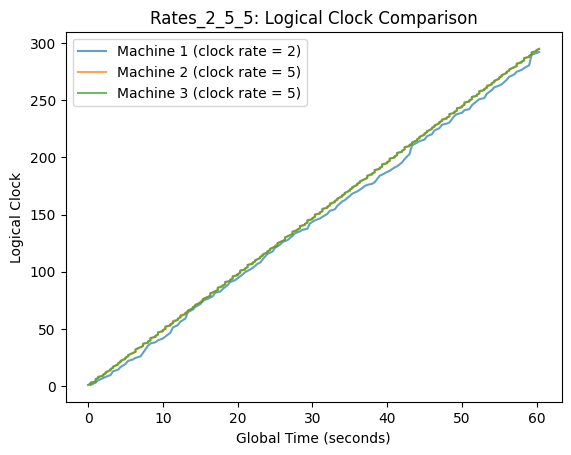

In [25]:
graph('logs/rates_2_5_5', 'logical clock')

We see that the normalized logical clock for Machines 2 and 3 matches the global clock, as they have the highest clock rate so there are no gaps. Additionally, we see that there are significant gaps for machine 2, causing its normalized logical clock to drift away from the global clock as it tries to keep pace with the logical clocks for the other machines. This matches exactly what we've seen in other sections as well.

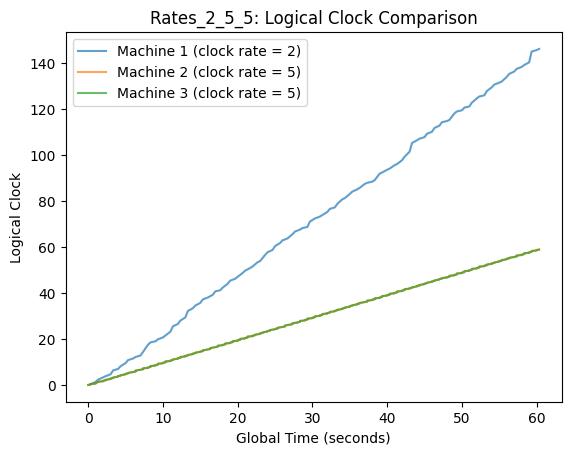

In [26]:
graph('logs/rates_2_5_5', 'logical clock', normal=True)

## Reducing internal event probability

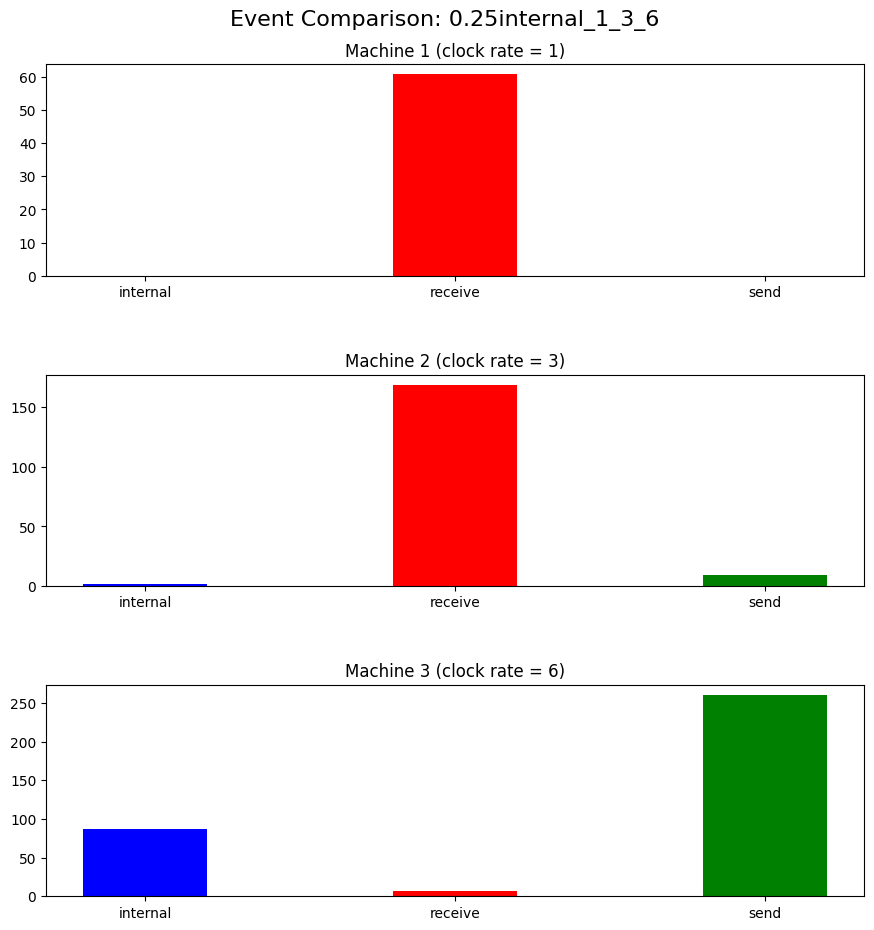

In [27]:
graph_events('logs/0.25internal_1_3_6')